In [102]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import gif
import time

In [103]:
def get_neighbours(grid_size: np.int64) -> npt.NDArray[np.int16]:
    L: np.int16 = int(np.sqrt(grid_size))
    neighbours = np.zeros((grid_size, 4), dtype=np.int16)
    for k in np.arange(grid_size):
        neighbours[k, 0] = k + 1
        if (k + 1) % L == 0:
            neighbours[k, 0] = k + 1 - L
        neighbours[k, 1] = k + L
        if k > (grid_size - L - 1):
            neighbours[k, 1] = k + L - grid_size
        neighbours[k, 2] = k - 1
        if k % L == 0:
            neighbours[k, 2] = k + L - 1
        neighbours[k, 3] = k - L
        if k < L:
            neighbours[k, 3] = k + grid_size - L
    return neighbours

In [104]:
# constants

SUSCEPTIBLE = 0
CONTAMINATED = 1
RECOVERED = 2

GRID_SIZE: np.int32 = 10000

RED = 1, 0, 0
BLUE = 0, 1, 0
GREEN = 0, 0, 1

COLORS: list[str] = [GREEN, RED, BLUE]
HEALTH_CONDITIONS_IDS: list[str] = ["Susceptible", "Contaminated", "Recovered"]

In [105]:
conditions: list[dict] = [
    {"prob_contamination": 0.9, "prob_recovery": 0.1},
    {"prob_contamination": 0.5, "prob_recovery": 0.5},
    {"prob_contamination": 0.1, "prob_recovery": 0.9}
]

In [128]:
# visualization functions


@gif.frame
def draw_grid(grid: npt.NDArray[np.int8], conditions: dict) -> None:
    cmap = colors.ListedColormap(colors=COLORS)
    bounds = [0, 1, 2]
    grid = np.reshape(grid, newshape=(int(np.sqrt(grid.size)), int(np.sqrt(grid.size))))
    plt.figure(figsize=(8, 4))
    plt.title(f"Propagação da doença\nProb. de contaminação: {conditions['prob_contamination']} Prob.de recuperação: {conditions['prob_recovery']}")
    plt.xlabel(f"{grid.shape} grid")
    plt.xticks(np.arange(grid.shape[0] + 1), labels=[])
    plt.yticks(np.arange(grid.shape[0] + 1), labels=[])
    patches = [
        mpatches.Patch(color=COLORS[i], label=f"{HEALTH_CONDITIONS_IDS[i]}")
        for i in np.arange(3)
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.imshow(
        grid,
        cmap=cmap,
        origin="lower",
        extent=(0, grid.shape[0], 0, grid.shape[0]),
        vmin=0,
        vmax=2,
    )


def create_gif(frames: npt.NDArray[np.int8], path: str) -> None:
    gif.save(frames, path, duration=200)

In [129]:
def spread(
    val: np.int8, neighbours_health: npt.NDArray[np.int16], conditions: dict
) -> np.int8:
    prob_contamination: np.float32 = conditions["prob_contamination"]
    prob_recovery: np.int32 = conditions["prob_recovery"]
    if val == SUSCEPTIBLE and (CONTAMINATED in neighbours_health):
        if np.random.rand() < prob_contamination:
            return CONTAMINATED
        else:
            return val
    elif val == CONTAMINATED:
        if np.random.rand() < prob_recovery:
            return RECOVERED
        else:
            return val
    else:
        return val


def generate_epidemic_process(
    grid: npt.NDArray[np.int8],
    conditions: dict,
    number_of_iterations: np.int8 = 100,
    gif: bool = False,
    plot_populations: bool = False,
    average_population: bool = False,
) -> npt.NDArray[np.int8]:
    neighbours: npt.NDArray[np.int16] = get_neighbours(grid.size)
    frames: list = []
    populations: npt.NDArray[np.int64] = np.zeros(
        shape=(3, number_of_iterations), dtype=np.int64
    )
    for i in np.arange(number_of_iterations):
        if gif:
            frames.append(draw_grid(grid=grid, conditions=conditions))
        if plot_populations:
            populations[0][i] = np.count_nonzero(grid == 0)
            populations[1][i] = np.count_nonzero(grid == 1)
            populations[2][i] = np.count_nonzero(grid == 2)
        grid = np.array(
            [
                spread(
                    val=val,
                    neighbours_health=grid[neighbours[idx]],
                    conditions=conditions,
                )
                for idx, val in enumerate(grid)
            ]
        )
    if gif:
        create_gif(frames, path=f"visualizations/example{time.time()}.gif")
    if plot_populations and not average_population:
        plt.title(
            f"Variação das populações\nProb. de contaminação: {conditions['prob_contamination']}\n Prob.de recuperação: {conditions['prob_recovery']}"
        )
        plt.xlabel("Iteração")
        plt.ylabel("Número de indivíduos")
        plt.plot(populations[0], label=f"{HEALTH_CONDITIONS_IDS[0]}", color="blue")
        plt.plot(populations[1], label=f"{HEALTH_CONDITIONS_IDS[1]}", color="red")
        plt.plot(populations[2], label=f"{HEALTH_CONDITIONS_IDS[2]}", color="green")
        plt.legend()
        plt.show()
    if plot_populations and average_population:
        return populations.astype(np.float64)


# Condições iniciais da rede

De modo a obter uma boa visualização do modelo SIR, uma rede de formato 100x100 foi escolhida, de modo que assim existirão 10000 indivíduos na simulação, número mais do que suficiente para analisar o comportamento do modelo para diferentes condições iniciais. Um número de iterações igual a 100 se mostrou um número seguro para garantir a convergência do sistema.

No entanto, tais parâmetros são facilmente manipuláveis e, ao fim das análises principais dos exercícios, alguns testes serão feitos testando as diferentes variações possíveis de condição da rede.

Em relação ao indivíduo contaminado inicial, sua posição foi escolhida aleatoriamente.

# Condições de contaminação e recuperação

As três condições de contaminação e recuperação utilizadas no exercício foram escolhidas com o objetivo de testar o comportamento do modelo para três casos principais, os dois extremos, em que a probabilidade de contaminação de um vizinho é de 90% e de recuperação é de 10%, e a situação simétrica, assim como o caso em que ambas probabilidades são 50%.

# Variação das populações

Como primeira parte da atividade, alguns gráficos mostrando a evolução das populações de cada tipo de indivíduo serão mostrados, com suas respectivas configurações iniciais disponibilizadas.

O primeiro experimento irá levar em consideração a forma como o sistema varia conforme o número de pacientes zero aumenta.

Inicialmente, os gráficos serão gerados para a condição inicial em que a probabilidade de contaminação dos indivíduos é 90%, e aprobabilidade de recuperaçã é de 10%.

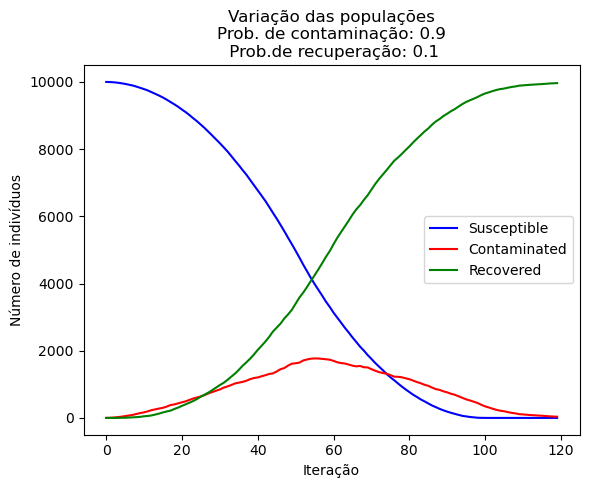

In [108]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=1)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[0], number_of_iterations=120, plot_populations=True)

Pode-se notar alguns comportamentos esperado para o sistema, como o fato dele convergir para um estado em que o número de indivíduos doentes é zero. Isso ocorre pois, com a quantidade suficiente de iterações, todos os indivíduos doentes eventualmente irão se recuperar e a rede chegará nesse estado de convergêcia. Podemos notar em particular o comportamento do gráfico do número de indivíduos doentes no ponto médio das iterações. Nesse momento o número de indivíduos doentes encontra seu valor máximo, a partir do qual ele começa a diminuir e convergir.

Poderemos analisar, posteriormente, que os valores das probabilidades de contaminação e recuperação afetam diretamente esses gráficos, uma vez que eles possuem uma relação direta com as características que os indivíduos terão a cada iteração do sistema.

Para ter uma interpretação ainda mais detalhada do que foi discutido, as mesmas condições foram utiizadas numa rede em que o número de pacientes doentes ao início do sistema é maior. Em particular, testaremos para 5, 10 e 20 indivíduos doentes também. 

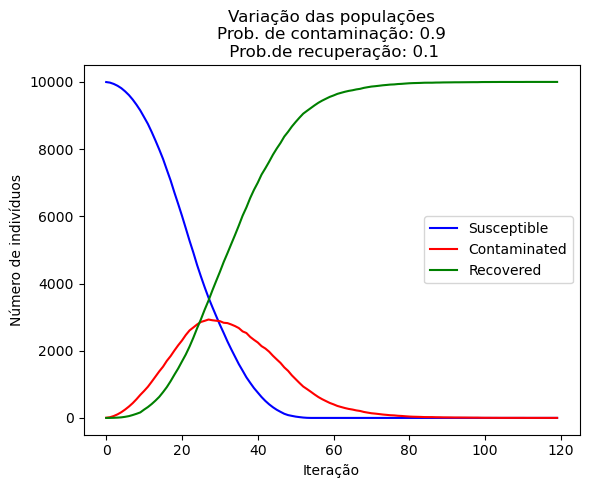

In [109]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=5)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[0], number_of_iterations=120, plot_populations=True)

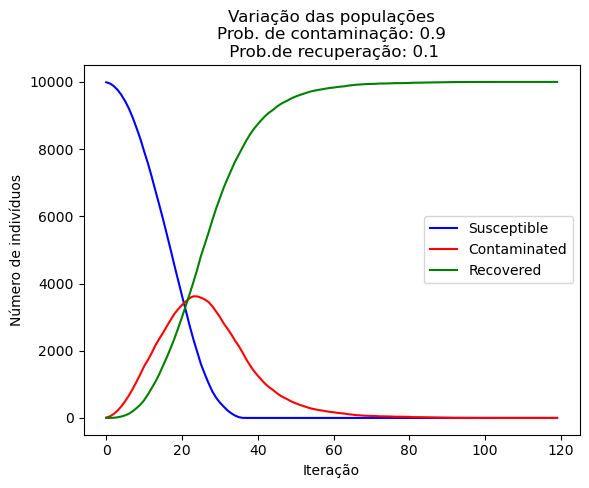

In [110]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=10)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[0], number_of_iterations=120, plot_populations=True)

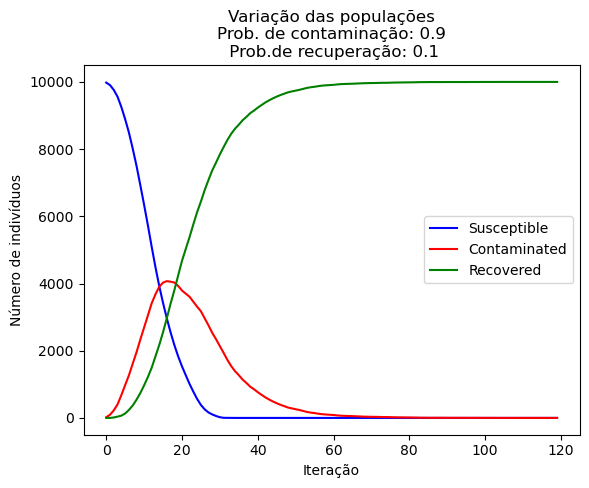

In [111]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=20)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[0], number_of_iterations=120, plot_populations=True)

De forma geral, duas coisas ficam nítidas em relação ao aumento do número de indivíduos doentes na condição inicial de cada rede,s endo elas:
- O sistema converge mais rapidamente, devido ao fato de que, com mais indivíduos doentes, mais indivíduos se recuperam e se tornam inertes, agilizando o processo de convergência.
- O número máximo de indivíduos doentes, no ponto de pico, aumenta, uma vez que, quanto mais indivíduos doentes inicialmente, mais indivíduos são contaminados e mais regiões da rede são contaminadas.

Em um segundo momento, a condição inicial que será testada será a oposta, isto é, a probabilidade de contaminação é de 10%, enquanto a probabilidade de recuperação é de 90%.

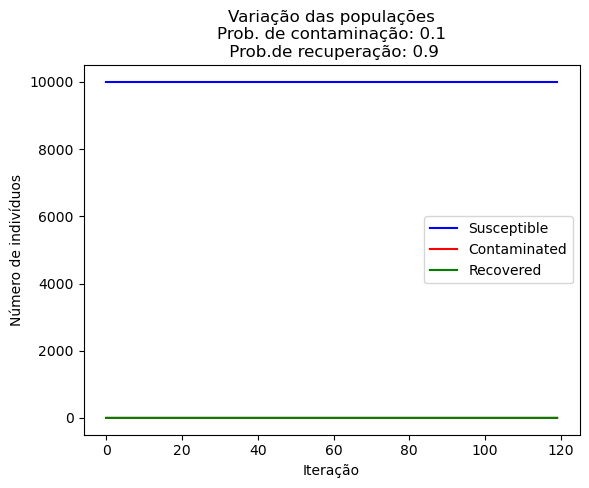

In [112]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=1)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[2], number_of_iterations=120, plot_populations=True)

Neste caso em particular, podemos notar uma condição extremamente estranha. Como, inicialmente, o número de indivíduos doentes é apenas um, e a probabilidade de recuperação é extremamente alta enquanto a probabilidade de contaminação é extremamente baixa, este indivíduo em particular se recupera e se torna inerte antes mesmo da doença se espalhar para mais indivíduos. Por isso, o gráfico se comporta durante todas as iterações dessa maneira estabilizada, sem variações.

É importante notar como esse comportamento será muito comum pra esta condição, independentemente de quantos pacientes zero existirem. Abaixo, podemos ver o gráfico para uma rede em que 50 pacientes zero existem, e podemos notar um comportamento extremamente similar ao visto anteriormente.

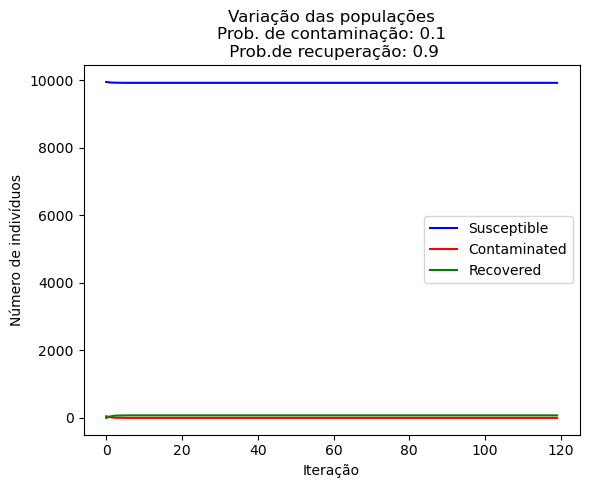

In [113]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=50)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[2], number_of_iterations=120, plot_populations=True)

Para uma terceira análise, foi escolhida a condição inicial em que as probabilidade de contaminação e recuperação são, respectivamente, 50%. Os resultados estão disponibilizados abaixo.

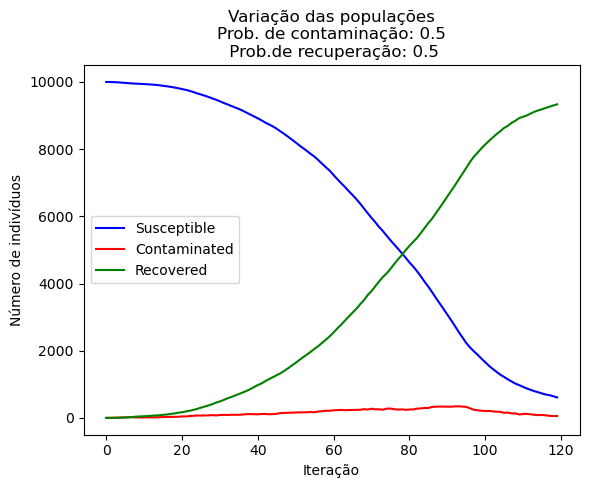

In [114]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=1)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[1], number_of_iterations=120, plot_populations=True)

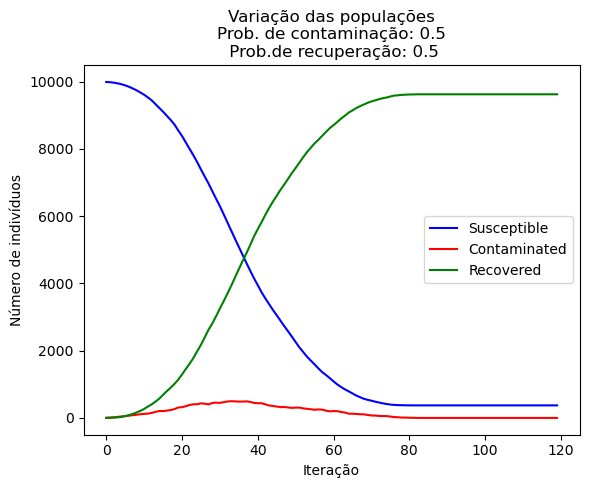

In [115]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=5)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[1], number_of_iterations=120, plot_populations=True)

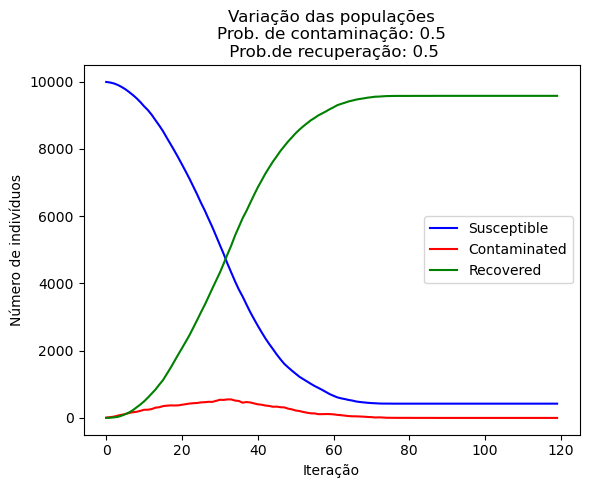

In [116]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=10)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[1], number_of_iterations=120, plot_populations=True)

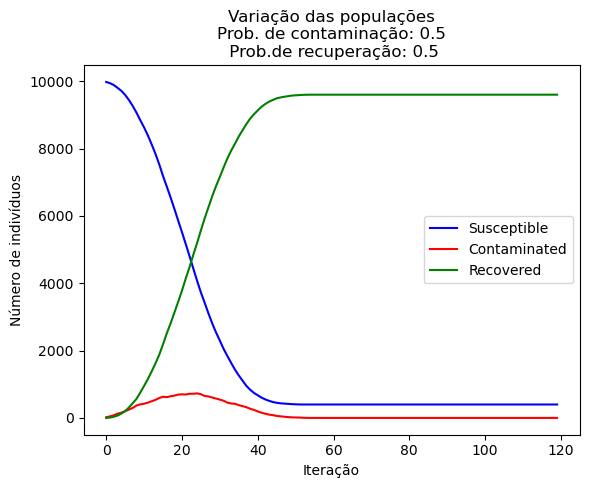

In [117]:
grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=20)
grid[pacients_zero] = 1
generate_epidemic_process(grid=grid, conditions=conditions[1], number_of_iterations=120, plot_populations=True)

Mais uma vez, geramos sistemas com uma quantidade de pacientes zero iguais a 1, 5, 10 e 20 e, novamente, mesmo em condições de contaminação e recuperação diferentes, nota-se que, com mais pacientes zero, mais rapidamente o sistema irá convergir e maior será o pico do gráfico do número de paciente infectados.

Neste segundo momento, considerando algumas condições iniciais diferentes, 10 experimentos serão realizados e a média destes experimentos será coletada, de modo a compreende, estatisticamente, como o modelo irá se comportar de modo geral para tais condições. Em particular, nessa sessão serão consideradas apenas as redes com um paciente zero.

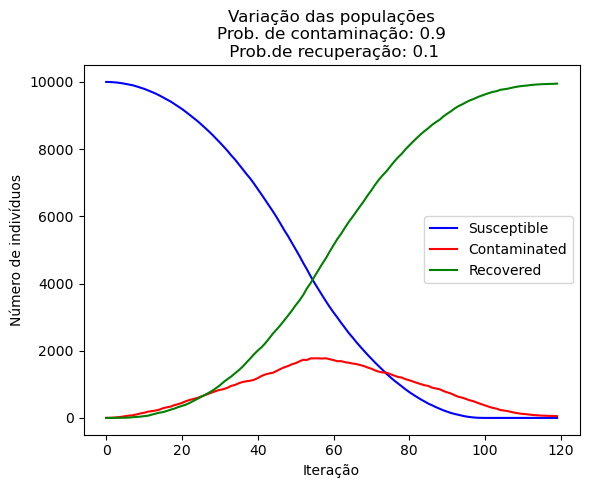

In [118]:
avg_populations: npt.NDArray[np.float64] = np.zeros(shape=(3, 120), dtype=np.float64)
for _ in range(10):
    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
    pacients_zero: npt.NDArray[np.int32] = np.random.randint(
        low=0, high=GRID_SIZE + 1, size=1
    )
    grid[pacients_zero] = 1
    populations = generate_epidemic_process(
        grid=grid,
        conditions=conditions[0],
        number_of_iterations=120,
        plot_populations=True,
        average_population=True
    )
    avg_populations += populations
avg_populations /= 10
plt.title(
    f"Variação das populações\nProb. de contaminação: {conditions[0]['prob_contamination']}\n Prob.de recuperação: {conditions[0]['prob_recovery']}"
)
plt.xlabel("Iteração")
plt.ylabel("Número de indivíduos")
plt.plot(populations[0], label=f"{HEALTH_CONDITIONS_IDS[0]}", color="blue")
plt.plot(populations[1], label=f"{HEALTH_CONDITIONS_IDS[1]}", color="red")
plt.plot(populations[2], label=f"{HEALTH_CONDITIONS_IDS[2]}", color="green")
plt.legend()
plt.show()

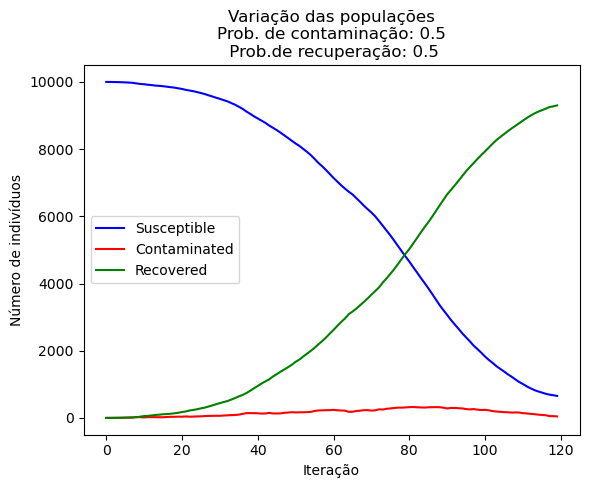

In [119]:
avg_populations: npt.NDArray[np.float64] = np.zeros(shape=(3, 120), dtype=np.float64)
for _ in range(10):
    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
    pacients_zero: npt.NDArray[np.int32] = np.random.randint(
        low=0, high=GRID_SIZE + 1, size=1
    )
    grid[pacients_zero] = 1
    populations = generate_epidemic_process(
        grid=grid,
        conditions=conditions[1],
        number_of_iterations=120,
        plot_populations=True,
        average_population=True
    )
    avg_populations += populations
avg_populations /= 10
plt.title(
    f"Variação das populações\nProb. de contaminação: {conditions[1]['prob_contamination']}\n Prob.de recuperação: {conditions[1]['prob_recovery']}"
)
plt.xlabel("Iteração")
plt.ylabel("Número de indivíduos")
plt.plot(populations[0], label=f"{HEALTH_CONDITIONS_IDS[0]}", color="blue")
plt.plot(populations[1], label=f"{HEALTH_CONDITIONS_IDS[1]}", color="red")
plt.plot(populations[2], label=f"{HEALTH_CONDITIONS_IDS[2]}", color="green")
plt.legend()
plt.show()

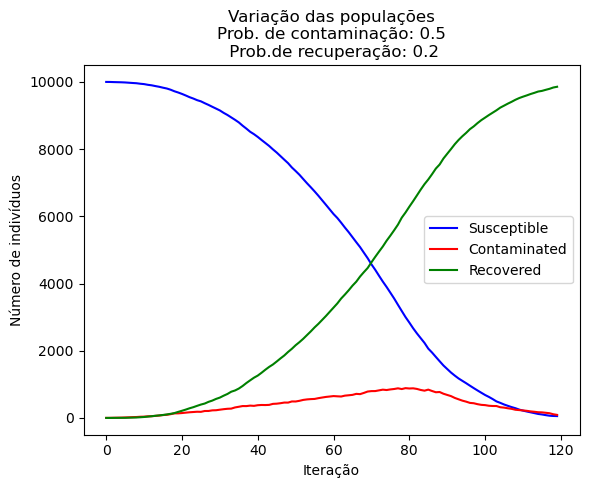

In [120]:
custom_conditions = {"prob_contamination": 0.5, "prob_recovery": 0.2}
avg_populations: npt.NDArray[np.float64] = np.zeros(shape=(3, 120), dtype=np.float64)
for _ in range(10):
    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
    pacients_zero: npt.NDArray[np.int32] = np.random.randint(
        low=0, high=GRID_SIZE + 1, size=1
    )
    grid[pacients_zero] = 1
    populations = generate_epidemic_process(
        grid=grid,
        conditions=custom_conditions,
        number_of_iterations=120,
        plot_populations=True,
        average_population=True
    )
    avg_populations += populations
avg_populations /= 10
plt.title(
    f"Variação das populações\nProb. de contaminação: {custom_conditions['prob_contamination']}\n Prob.de recuperação: {custom_conditions['prob_recovery']}"
)
plt.xlabel("Iteração")
plt.ylabel("Número de indivíduos")
plt.plot(populations[0], label=f"{HEALTH_CONDITIONS_IDS[0]}", color="blue")
plt.plot(populations[1], label=f"{HEALTH_CONDITIONS_IDS[1]}", color="red")
plt.plot(populations[2], label=f"{HEALTH_CONDITIONS_IDS[2]}", color="green")
plt.legend()
plt.show()

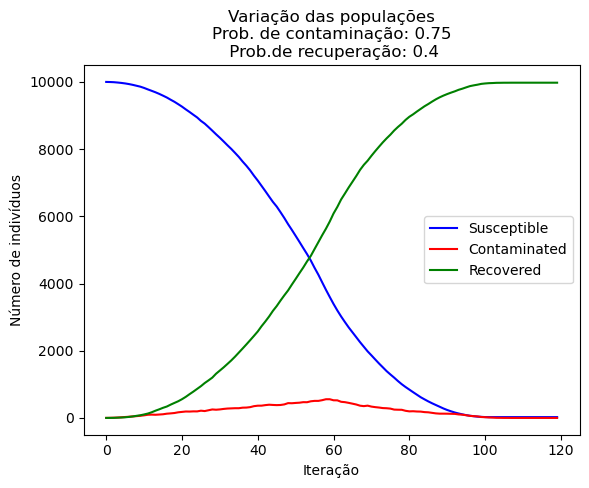

In [121]:
custom_conditions = {"prob_contamination": 0.75, "prob_recovery": 0.4}
avg_populations: npt.NDArray[np.float64] = np.zeros(shape=(3, 120), dtype=np.float64)
for _ in range(10):
    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
    pacients_zero: npt.NDArray[np.int32] = np.random.randint(
        low=0, high=GRID_SIZE + 1, size=1
    )
    grid[pacients_zero] = 1
    populations = generate_epidemic_process(
        grid=grid,
        conditions=custom_conditions,
        number_of_iterations=120,
        plot_populations=True,
        average_population=True
    )
    avg_populations += populations
avg_populations /= 10
plt.title(
    f"Variação das populações\nProb. de contaminação: {custom_conditions['prob_contamination']}\n Prob.de recuperação: {custom_conditions['prob_recovery']}"
)
plt.xlabel("Iteração")
plt.ylabel("Número de indivíduos")
plt.plot(populations[0], label=f"{HEALTH_CONDITIONS_IDS[0]}", color="blue")
plt.plot(populations[1], label=f"{HEALTH_CONDITIONS_IDS[1]}", color="red")
plt.plot(populations[2], label=f"{HEALTH_CONDITIONS_IDS[2]}", color="green")
plt.legend()
plt.show()

Pode-se checar nestes gráficos as populações médias de cada tipo de indivíduo para diferentes configurações de propagação da doença. É notável como, ao fazer a média de 10 iterações, o gŕafico se torna mais suave e melhor de se analisar visualmente.

Por fim, para mostrar o comportamento do espalhamento das doenças, foram criados alguns *gifs* que contêm o espalhamento da doença na rede para diferentes configurações. Estes *gifs* estão salvos no diretório *visualizations*, e também estão sendo enviados juntamente à este PDF.

In [130]:
for i in range(len(conditions)):
    grid: npt.NDArray[np.int8] = np.zeros(shape=GRID_SIZE)
    pacients_zero: npt.NDArray[np.int32] = np.random.randint(low=0, high=GRID_SIZE+1, size=1)
    grid[pacients_zero] = 1
    generate_epidemic_process(grid=grid, conditions=conditions[i], number_of_iterations=120, gif=True)